In [1]:
from netCDF4 import Dataset
import csv
import numpy as np
import warnings
import glob, os
import cv2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from math import *

#Geodesic distance in km
def dist_geo(long1, lat1, long2, lat2):
    try:
        value= sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360)
        return acos(min(1,value))*6378
    except ValueError:
        print(long1, lat1, long2, lat2,sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360))

#Geodesic distance for vectors
vdist_geo = np.vectorize(dist_geo, excluded=['long1', 'lat1'])

#Returns the distances and indices of k-nearest neighbors from the point (long,lat)
def get_knearest(long, lat, points, indices, k):
    distances = vdist_geo(long, lat, points[:,0], points[:,1])
    s_distances, s_neigh = (np.array(t) for t in zip(*sorted(zip(distances, indices))))
    return s_distances[:k], s_neigh[:k]

#Compute alpha weight from i-th point in distances
def alpha(distances, i, coeff):
    return exp(-distances[i]/coeff)/sum(np.exp(-np.array(distances)/coeff))

#Compute alphas weights for all points in distances
def valpha(distances, coeff):
    l = len(distances)
    alphas = np.zeros((l,))
    for i in range(l):
        alphas[i] = alpha(distances, i, coeff)
    return alphas

def non_nan_hist(values, non_nan_indexes, bins):
    hist, b = np.histogram(values[non_nan_indexes], bins)
    hist = hist.ravel().astype('float32')
    return hist, b

In [3]:
with open('NATL12_GSbox_PCM_profils.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='|')
    i = 0;
    profile_means = np.zeros((4,36))
    profile_std = np.zeros((4,36))
    for row in reader:
        if i > 0:
            profile_means[:,i-1] = np.array(row).astype(float)[0:4]
            profile_std[:,i-1] = np.array(row).astype(float)[4:8]
        i+=1
depth_std = np.mean(profile_std, axis=0)

In [47]:
os.chdir('D:/Documents/telecom bretagne/F4B/projet-s5/PROJETS5_Lx24Ly24-3D')
st = "NATL12_*.nc"
n_iter = 0 #Number of time iterations 
for file in glob.glob(st):
    n_iter+= 1
print(n_iter)

75


In [48]:
dataset = Dataset("NATL12_iter0001_nobs025_draw001.nc")
dpt = np.array(dataset['dpt'])

In [58]:
colors = ['g','r','y','b'] #Colors used to display classes
ref_ind = 25
ref_means = profile_means[:, ref_ind] #class means at -365 m
n_neigh = 8 #Number of neighbors to consider
alpha_coeff = 70 #Coefficient to compute alpha weights for basic temperature estimation and posteriors estimation

all_basic_temp = np.zeros((n_iter,127,254,36))
all_true_temp = np.zeros((n_iter,127,254,36))
all_est_post = np.zeros((n_iter,4,127,254)) #Estimation of posteriors
ite = 0
for file in glob.glob(st):
    print(ite+1)
    dataset = Dataset(file)
    long = np.array(dataset['lon']) #Whole data longitudes
    lat = np.array(dataset['lat']) #Whole data latitudes
    #lab = np.reshape(np.array(dataset['labels']), (127,254)) #Whole data classes  
    posteriors = np.reshape(dataset['posteriors'],(4,127,254)) #Whole data posteriors
    obs_lon = dataset['obs_lon'] #Observations longtitudes
    obs_lat = dataset['obs_lat'] #Observations latitudes
    n_obs = len(obs_lon)
    obs_ilon = np.array(dataset['obs_ilon']).astype(int)-1 #Observations indices in "long"
    obs_ilat = np.array(dataset['obs_ilat']).astype(int)-1 #Observations indices in "lat"
    #class_obs = lab[obs_ilon,obs_ilat].astype(int) #Observations classes
    all_true_temp[ite,:,:,:] = np.reshape(dataset['temperature'],(127,254,36)) #Whole data temperature

    
    #noise = numpy.random.normal(size=(127,254), scale = depth_std[d])
    n_temp = all_true_temp[ite,:,:,:] #+ noise
    
    for i in range(127):
        for j in range(254):
            if all(np.isnan(n_temp[i,j,:])) == False:
                lon = long[i,j]
                lati = lat[i,j]
                distances, knearest = get_knearest(lon, lati, np.column_stack((obs_lon, obs_lat)),\
                                                           np.column_stack((obs_ilon, obs_ilat)), n_neigh)
                alphas = valpha(distances, alpha_coeff)
                for d in range(36):
                    #threeD_basic_temp[i,j,d] = sum(alphas*n_temp[knearest[:,0],knearest[:,1]])
                    all_basic_temp[ite,i,j,d] = sum(alphas*n_temp[knearest[:,0],knearest[:,1],d])
                    if d == ref_ind:
                        all_est_post[ite,:,i,j] = alphas.dot(np.transpose(posteriors[:,knearest[:,0],knearest[:,1]]))
                        #est_lab[i,j] = np.argmax(est_post[:,i,j])
    ite +=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [59]:
all_wta_learnt_temp = np.zeros((n_iter,127,254,36))
all_mixed_learnt_temp = np.zeros((n_iter,127,254,36))
for i in range(127):
    for j in range(254):
        for ite in range(n_iter):
            all_wta_learnt_temp[ite,i,j,:] = profile_means[int(np.argmax(all_est_post[ite,:,i,j])),:]
            all_mixed_learnt_temp[ite,i,j,:] = all_est_post[ite,:,i,j].dot(profile_means)

2.0526155004
2.96144984916
2.71435607278


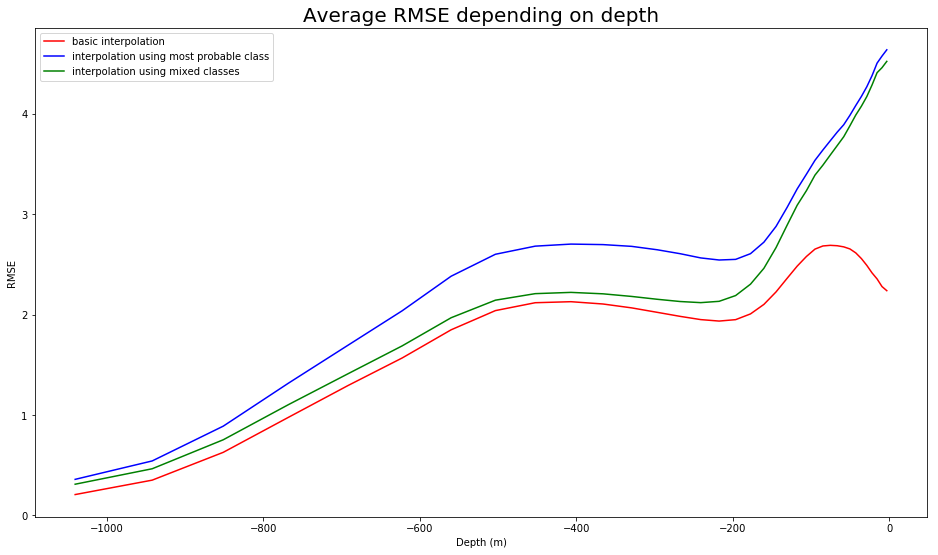

In [67]:
basic_rmse = np.sqrt(np.nanmean((all_basic_temp - all_true_temp)**2,axis=(0, 1, 2)))
wta_learnt_rmse = np.sqrt(np.nanmean((all_wta_learnt_temp - all_true_temp)**2,axis=(0, 1, 2)))
mixed_learnt_rmse = np.sqrt(np.nanmean((all_mixed_learnt_temp - all_true_temp)**2,axis=(0, 1, 2)))

plot(dpt,basic_rmse,'r',label='basic interpolation')
plot(dpt,wta_learnt_rmse,'b', label='interpolation using most probable class')
plot(dpt,mixed_learnt_rmse,'g', label='interpolation using mixed classes')
legend()
title('Average RMSE depending on depth', fontsize= 20)
xlabel('Depth (m)')
ylabel('RMSE')
print(np.mean(basic_rmse))
print(np.mean(wta_learnt_rmse))
print(np.mean(mixed_learnt_rmse))

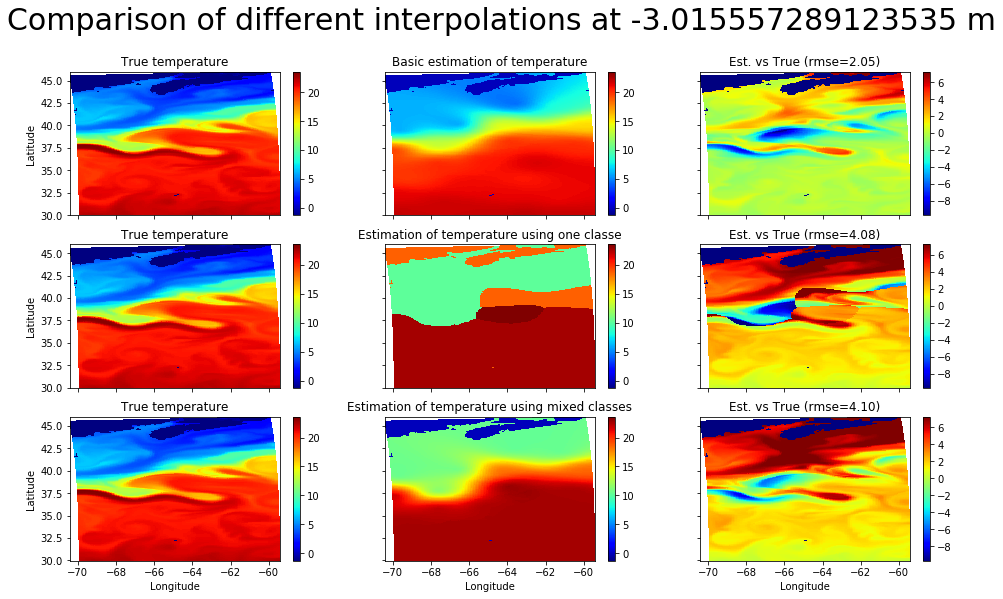

In [63]:
import copy
pylab.rcParams['figure.figsize'] = (16,9)
warnings.filterwarnings('ignore')
ind = 0
ite = 0
titles = ['Basic estimation of temperature', 'Estimation of temperature using one classe', \
          'Estimation of temperature using mixed classes']
all_temp = [all_basic_temp[ite,:,:,ind], all_wta_learnt_temp[ite,:,:,ind], all_mixed_learnt_temp[ite,:,:,ind]]
ref = copy.copy(all_true_temp[ite,:,:,ind])
tmin, tmax = np.nanmin(ref), np.nanmax(ref)
rmin, rmax = np.nanmin(all_temp[0]-ref), np.nanmax(all_temp[0]-ref)
f, axarr = plt.subplots(3, 3, sharex='col', sharey='row')
for k in range(3):
    p = axarr[k,0].pcolor(long, lat, ref, cmap=cm.jet, vmin=tmin, vmax=tmax)
    cb = f.colorbar(p, ax=axarr[k,0])
    axarr[k,0].set_title('True temperature')
    axarr[k,0].set_ylabel('Latitude')
    p = axarr[k,1].pcolor(long, lat, all_temp[k], cmap=cm.jet, vmin=tmin, vmax=tmax)
    cb = f.colorbar(p, ax=axarr[k,1])
    axarr[k,1].set_title("%s"%(titles[k]))
    p = axarr[k,2].pcolor(long, lat, all_temp[k]-ref, cmap=cm.jet, vmin=rmin, vmax=rmax)
    cb = f.colorbar(p, ax=axarr[k,2])
    rms = np.sqrt(np.nanmean(np.array(all_temp[k]-ref)**2))
    axarr[k,2].set_title("Est. vs True (rmse=%0.2f)"%(rms))

for k in range(3):
    axarr[2,k].set_xlabel('Longitude')
f.suptitle('Comparison of different interpolations at {0} m'.format(dpt[ind]),fontsize=30)



In [10]:
a = [8, 10]
print(any(np.isnan(a)))

False


In [61]:
np.save("true_temp", all_true_temp)

In [62]:
np.save("basic_temp", all_basic_temp)